# DA — Brazilian E‑Commerce Customer Segmentation
**Project:** Customer segmentation for a Brazilian e‑commerce dataset (generalizable template).  
**Author:** Generated and polished for GitHub by assistant.  
**Notebook goals:** Data ingestion, cleaning, feature engineering (customer-level), EDA, K-Means segmentation, visualizations, and saving results.  


In [14]:
# 1. Import libraries and configure environment
import os
from pathlib import Path
import logging
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Data paths (modify if needed)
DATA_PATHS = {
    'customers': 'archive/olist_customers_dataset.csv',
    'orders': 'archive/olist_orders_dataset.csv',
    'payments': 'archive/olist_order_payments_dataset.csv',
    'items': 'archive/olist_order_items_dataset.csv',
    'products': 'archive/olist_products_dataset.csv',
    'fe_output': 'olist_feature_engineering_outputs/customer_features_engineered.csv'
}
OUTPUT_DIR = Path('analysis_outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

logging.info('Environment configured.')


2025-10-19 23:22:52,360 - INFO - Environment configured.


In [15]:
# 2. Load datasets (robust) and merge into a single dataframe for feature engineering
def load_csv(path, usecols=None, dtype=None, parse_dates=None, nrows=None):
    path = Path(path)
    logging.info(f'Loading {path}')
    return pd.read_csv(path, usecols=usecols, dtype=dtype, parse_dates=parse_dates, nrows=nrows)

# We keep dtype maps small here; adapt to your data to improve memory usage.
try:
    customers = load_csv(DATA_PATHS['customers'])
    orders = load_csv(DATA_PATHS['orders'], parse_dates=['order_purchase_timestamp', 'order_approved_at',
                                                         'order_delivered_carrier_date', 'order_delivered_customer_date',
                                                         'order_estimated_delivery_date'])
    payments = load_csv(DATA_PATHS['payments'])
    items = load_csv(DATA_PATHS['items'])
    products = load_csv(DATA_PATHS['products'])
    logging.info('All source CSVs loaded.')
except Exception as e:
    logging.error('Failed to load one or more CSVs: %s', e)
    raise

# Merge datasets: orders + customers + payments + items + products
df = orders.merge(customers, on='customer_id', how='left')
df = df.merge(payments, on='order_id', how='left')
df = df.merge(items, on='order_id', how='left')
df = df.merge(products, on='product_id', how='left')

logging.info('Merged dataframe shape: %s', df.shape)
df.head()


2025-10-19 23:22:52,374 - INFO - Loading archive\olist_customers_dataset.csv
2025-10-19 23:22:52,551 - INFO - Loading archive\olist_orders_dataset.csv
2025-10-19 23:22:53,010 - INFO - Loading archive\olist_order_payments_dataset.csv
2025-10-19 23:22:53,118 - INFO - Loading archive\olist_order_items_dataset.csv
2025-10-19 23:22:53,312 - INFO - Loading archive\olist_products_dataset.csv
2025-10-19 23:22:53,352 - INFO - All source CSVs loaded.
2025-10-19 23:22:53,773 - INFO - Merged dataframe shape: (118434, 30)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,credit_card,1.0,18.12,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3.0,voucher,1.0,2.00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2.0,voucher,1.0,18.59,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,boleto,1.0,141.46,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,credit_card,3.0,179.12,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0


In [16]:
# 3. Initial inspection and cleaning
# Show missing values and duplicated column names
print('Missing values (top 20):')
display(df.isna().sum().sort_values(ascending=False).head(20))

duplicated_cols = df.columns[df.columns.duplicated()]
if not duplicated_cols.empty:
    logging.warning('Duplicated column names found: %s', duplicated_cols.tolist())
else:
    logging.info('No duplicated columns found.')

# Convert common date columns to datetime if they are not already
date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
             'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date']
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# Attempt to coerce numeric-like object columns to numeric where reasonable
for col in df.select_dtypes(include=['object']).columns:
    # detect numeric-like strings with at least 60% coercible values
    coerced = pd.to_numeric(df[col].astype(str).str.replace(r'[^0-9.-]', '', regex=True), errors='coerce')
    non_null = df[col].notna().sum()
    if non_null > 0 and coerced.notna().sum() / non_null >= 0.6:
        df[col] = coerced

# Convert other numerical-looking columns
for col in df.select_dtypes(include=['number']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

logging.info('Types after coercion:')
display(df.dtypes)


Missing values (top 20):


order_delivered_customer_date    3397
product_photos_qty               2528
product_category_name            2528
product_name_lenght              2528
product_description_lenght       2528
order_delivered_carrier_date     2074
product_weight_g                  850
product_length_cm                 850
product_height_cm                 850
product_width_cm                  850
price                             830
freight_value                     830
shipping_limit_date               830
seller_id                         830
order_item_id                     830
product_id                        830
order_approved_at                 176
payment_type                        3
payment_value                       3
payment_sequential                  3
dtype: int64

2025-10-19 23:22:53,868 - INFO - No duplicated columns found.
2025-10-19 23:22:56,615 - INFO - Types after coercion:


order_id                                float64
customer_id                             float64
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_unique_id                      float64
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
payment_sequential                      float64
payment_type                             object
payment_installments                    float64
payment_value                           float64
order_item_id                           float64
product_id                              float64
seller_id                               float64
shipping_limit_date              datetime64[ns]
price                                   

In [17]:
# 4. Missing value handling and filtering
# Fill categorical columns with mode and numeric with median
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
date_cols = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()

for c in cat_cols:
    if df[c].isna().sum() > 0:
        mode_val = df[c].mode().iat[0] if not df[c].mode().empty else 'Unknown'
        df[c] = df[c].fillna(mode_val)

for c in num_cols:
    if df[c].isna().sum() > 0:
        df[c] = df[c].fillna(df[c].median())

for c in date_cols:
    if df[c].isna().sum() > 0:
        df[c] = df[c].fillna(df[c].median())

# Drop rows that are essential for the analysis
required_cols = ['customer_unique_id', 'order_purchase_timestamp', 'payment_value', 'product_category_name']
df.dropna(subset=required_cols, inplace=True)

# Keep only delivered orders (focus on fulfilled sales)
if 'order_status' in df.columns:
    df = df[df['order_status'] == 'delivered'].copy()

logging.info('After cleaning, dataframe shape: %s', df.shape)
display(df.isna().sum().sort_values(ascending=False).head(15))


2025-10-19 23:22:56,859 - INFO - After cleaning, dataframe shape: (115038, 30)


order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
payment_sequential               0
payment_type                     0
payment_installments             0
dtype: int64

In [18]:
# 5. Feature engineering at customer level (RFM + behavioral features)
logging.info('Starting feature engineering...')

# Snapshot date: one day after last purchase in data (used to compute Recency)
snapshot_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# RFM aggregation
rfm = df.groupby('customer_unique_id').agg(
    Recency=('order_purchase_timestamp', lambda x: (snapshot_date - x.max()).days),
    Frequency=('order_id', 'nunique'),
    Monetary=('payment_value', 'sum')
).reset_index()

# Tenure and average monetary per order
tenure = df.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index().rename(columns={'order_purchase_timestamp':'first_purchase_date'})
tenure['Tenure'] = (snapshot_date - tenure['first_purchase_date']).dt.days
rfm = rfm.merge(tenure[['customer_unique_id','Tenure']], on='customer_unique_id', how='left')
rfm['avg_monetary'] = rfm['Monetary'] / rfm['Frequency']

# Behavioral timing features: average days between orders
orders_sorted = df[['customer_unique_id','order_purchase_timestamp']].sort_values(['customer_unique_id','order_purchase_timestamp'])
orders_sorted['days_since_previous'] = orders_sorted.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days
avg_days = orders_sorted.groupby('customer_unique_id')['days_since_previous'].mean().reset_index().rename(columns={'days_since_previous':'avg_days_between_orders'})
rfm = rfm.merge(avg_days, on='customer_unique_id', how='left')
rfm['avg_days_between_orders'] = rfm['avg_days_between_orders'].fillna(0)

# Favorite purchase day and hour
df['purchase_day_of_week'] = df['order_purchase_timestamp'].dt.day_name()
df['purchase_hour'] = df['order_purchase_timestamp'].dt.hour

fav_day = df.groupby('customer_unique_id')['purchase_day_of_week'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else None).reset_index().rename(columns={'purchase_day_of_week':'favorite_purchase_day'})
fav_hour = df.groupby('customer_unique_id')['purchase_hour'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else None).reset_index().rename(columns={'purchase_hour':'favorite_purchase_hour'})
rfm = rfm.merge(fav_day, on='customer_unique_id', how='left')
rfm = rfm.merge(fav_hour, on='customer_unique_id', how='left')

# Product interaction features
distinct_cats = df.groupby('customer_unique_id')['product_category_name'].nunique().reset_index().rename(columns={'product_category_name':'distinct_categories_purchased'})
rfm = rfm.merge(distinct_cats, on='customer_unique_id', how='left')

fav_cat = df.groupby(['customer_unique_id','product_category_name'])['payment_value'].sum().reset_index()
fav_cat = fav_cat.loc[fav_cat.groupby('customer_unique_id')['payment_value'].idxmax()].rename(columns={'product_category_name':'favorite_category'})
rfm = rfm.merge(fav_cat[['customer_unique_id','favorite_category']], on='customer_unique_id', how='left')

items_per_order = df.groupby(['customer_unique_id','order_id'])['order_item_id'].max().reset_index()
avg_items = items_per_order.groupby('customer_unique_id')['order_item_id'].mean().reset_index().rename(columns={'order_item_id':'avg_items_per_order'})
rfm = rfm.merge(avg_items, on='customer_unique_id', how='left')

# Finalize customer dataframe
customer_df = rfm.set_index('customer_unique_id')
logging.info('Feature engineering completed. Customer table shape: %s', customer_df.shape)
display(customer_df.head())


2025-10-19 23:22:56,892 - INFO - Starting feature engineering...
2025-10-19 23:23:32,667 - INFO - Feature engineering completed. Customer table shape: (93358, 11)


,Recency,Frequency,Monetary,Tenure,avg_monetary,avg_days_between_orders,favorite_purchase_day,favorite_purchase_hour,distinct_categories_purchased,favorite_category,avg_items_per_order
customer_unique_id,,,,,,,,,,,
5949650.0,254,1,164.24,254,164.24,0.0,Monday,22,1,beleza_saude,1.0
36248220.0,410,1,144.78,410,144.78,0.0,Saturday,17,1,moveis_escritorio,1.0
55164271.0,528,1,222.07,528,222.07,0.0,Sunday,21,1,beleza_saude,1.0
72071011.0,298,1,172.09,298,172.09,0.0,Saturday,21,1,moveis_escritorio,1.0
222018895.0,8,1,106.31,8,106.31,0.0,Tuesday,19,1,perfumaria,1.0


In [19]:
# 6. Save engineered customer features (CSV)
output_dir = OUTPUT_DIR / 'feature_engineering_outputs'
output_dir.mkdir(parents=True, exist_ok=True)
fe_path = output_dir / 'customer_features_engineered.csv'
customer_df.to_csv(fe_path)
logging.info('Saved engineered features to %s', fe_path)
fe_path


2025-10-19 23:23:33,166 - INFO - Saved engineered features to analysis_outputs\feature_engineering_outputs\customer_features_engineered.csv


WindowsPath('analysis_outputs/feature_engineering_outputs/customer_features_engineered.csv')

2025-10-19 23:23:35,026 - INFO - Saved histograms to analysis_outputs\feature_engineering_outputs\feature_distributions_histograms.png


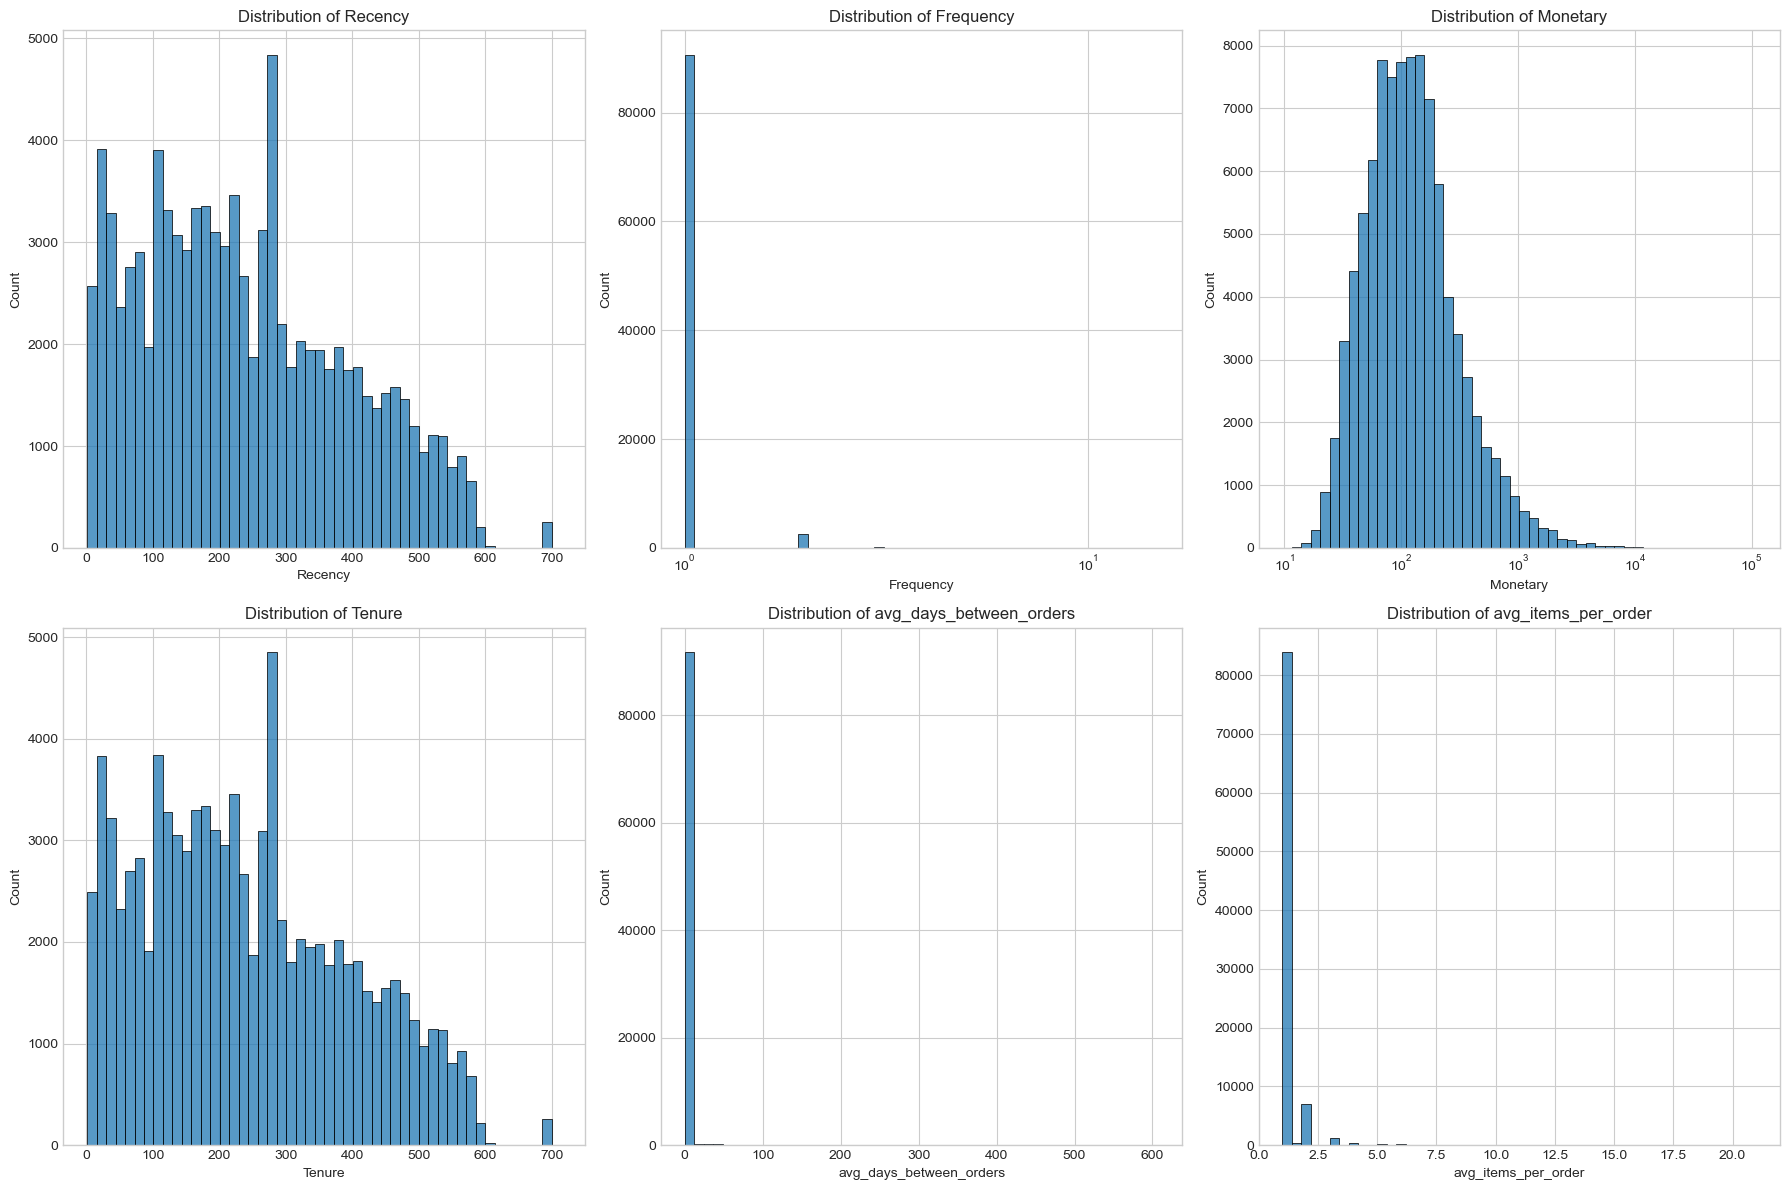

In [20]:
# 7. EDA — Distributions of key numerical features
import math
features_to_plot = ['Recency', 'Frequency', 'Monetary', 'Tenure', 'avg_days_between_orders', 'avg_items_per_order']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    series = customer_df[feature].dropna()
    use_log = feature in ['Frequency', 'Monetary']
    if use_log:
        sns.histplot(series, bins=50, kde=False, log_scale=True)
    else:
        sns.histplot(series, bins=50, kde=False)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
hist_path = output_dir / 'feature_distributions_histograms.png'
plt.savefig(hist_path, dpi=150, bbox_inches='tight')
logging.info('Saved histograms to %s', hist_path)
plt.show()


2025-10-19 23:23:36,168 - INFO - Saved correlation heatmap to analysis_outputs\feature_engineering_outputs\feature_correlation_heatmap.png


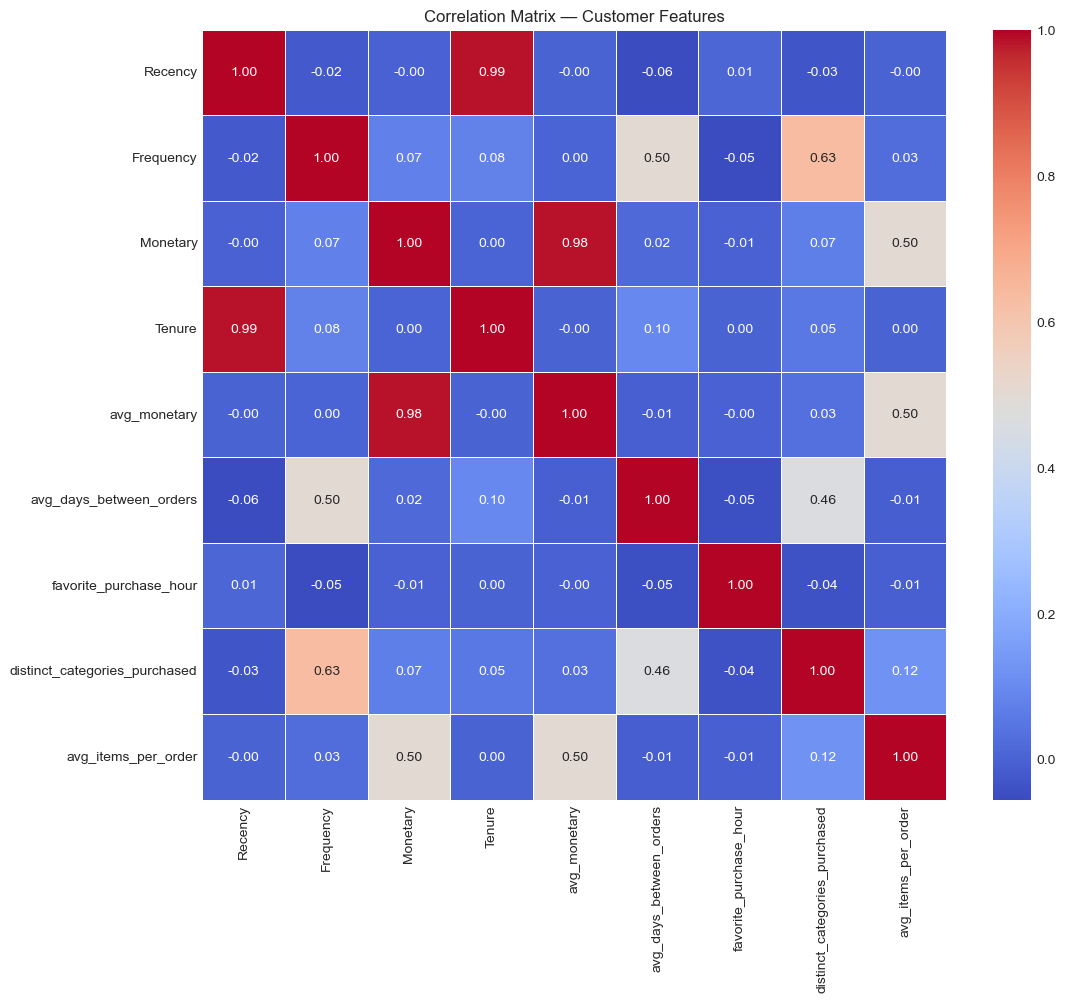

In [21]:
# 8. Correlation matrix for numeric features
numeric_df = customer_df.select_dtypes(include=[np.number]).copy()
plt.figure(figsize=(12,10))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix — Customer Features')
heatmap_path = output_dir / 'feature_correlation_heatmap.png'
plt.savefig(heatmap_path, dpi=150, bbox_inches='tight')
logging.info('Saved correlation heatmap to %s', heatmap_path)
plt.show()


2025-10-19 23:23:36,583 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-19 23:23:36,671 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-19 23:23:36,945 - INFO - Saved favorite day plot to analysis_outputs\feature_engineering_outputs\favorite_purchase_day_dist.png


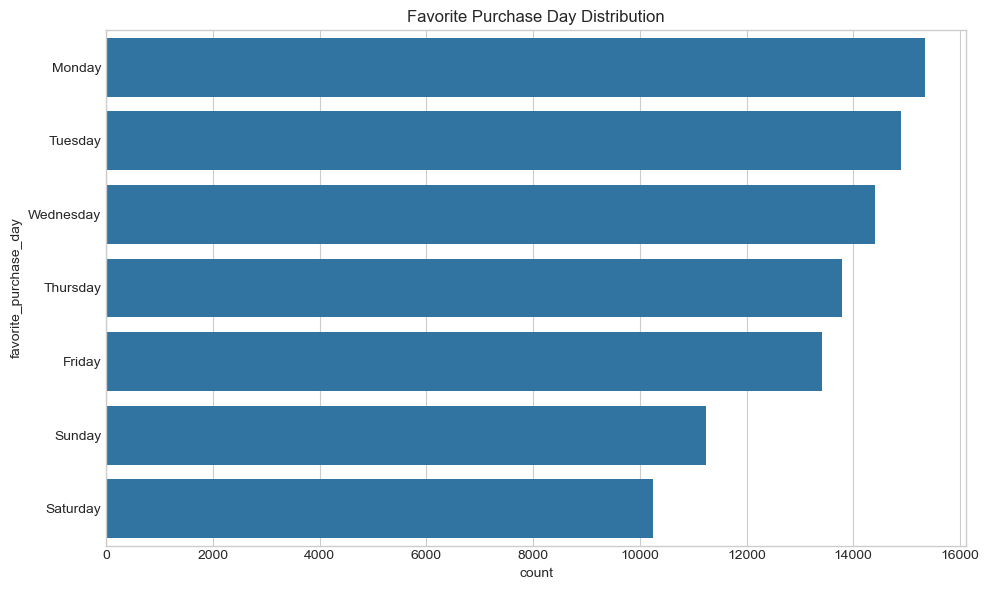

2025-10-19 23:23:37,143 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-19 23:23:37,199 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-19 23:23:37,532 - INFO - Saved favorite hour plot to analysis_outputs\feature_engineering_outputs\favorite_purchase_hour_dist.png


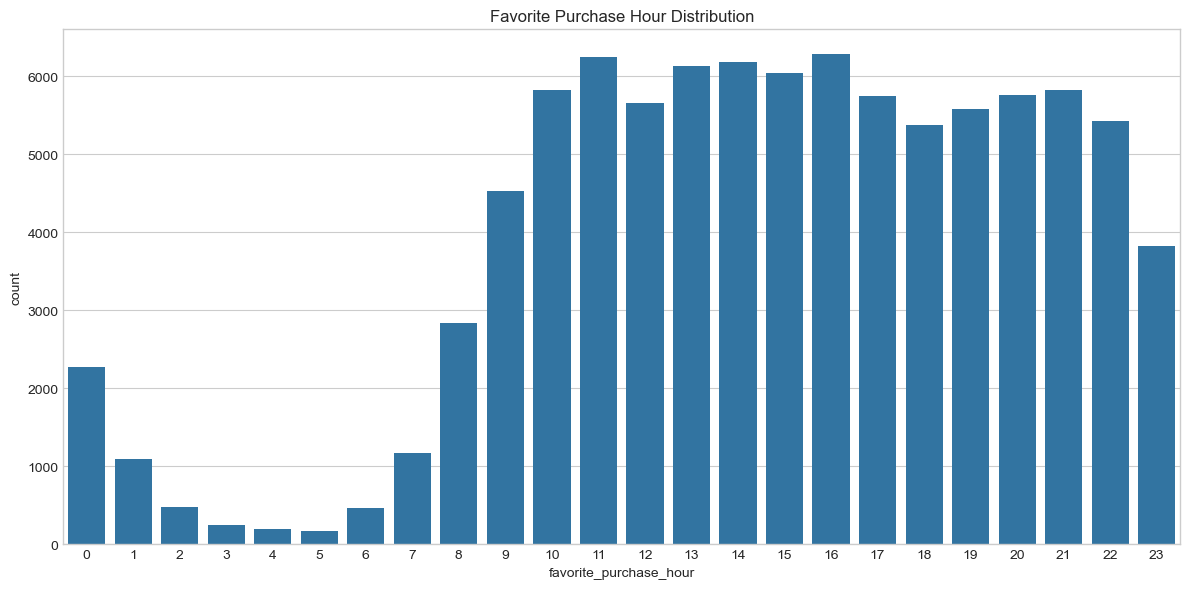

In [22]:
# 9. Categorical analysis: favorite day & hour distributions
# Favorite purchase day distribution
plt.figure(figsize=(10,6))
order = customer_df['favorite_purchase_day'].value_counts().index if 'favorite_purchase_day' in customer_df else None
sns.countplot(y='favorite_purchase_day', data=customer_df.reset_index(), order=order)
plt.title('Favorite Purchase Day Distribution')
plt.tight_layout()
fav_day_path = output_dir / 'favorite_purchase_day_dist.png'
plt.savefig(fav_day_path, dpi=150, bbox_inches='tight')
logging.info('Saved favorite day plot to %s', fav_day_path)
plt.show()

# Favorite purchase hour distribution
plt.figure(figsize=(12,6))
sns.countplot(x='favorite_purchase_hour', data=customer_df.reset_index())
plt.title('Favorite Purchase Hour Distribution')
plt.tight_layout()
fav_hour_path = output_dir / 'favorite_purchase_hour_dist.png'
plt.savefig(fav_hour_path, dpi=150, bbox_inches='tight')
logging.info('Saved favorite hour plot to %s', fav_hour_path)
plt.show()


In [23]:
# 10. Preprocessing numeric features for clustering
numeric_features = customer_df.select_dtypes(include=[np.number]).copy()
logging.info('Numeric features selected for clustering: %s', list(numeric_features.columns))

# Fill any remaining NaNs with median
for col in numeric_features.columns:
    if numeric_features[col].isnull().any():
        numeric_features[col].fillna(numeric_features[col].median(), inplace=True)

# Apply log1p to skewed columns (safe transform)
numeric_features = numeric_features.apply(lambda x: np.log1p(x) if (x.min() >= 0) else x)

scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(numeric_features), index=numeric_features.index, columns=numeric_features.columns)
display(features_scaled.head())


2025-10-19 23:23:37,691 - INFO - Numeric features selected for clustering: ['Recency', 'Frequency', 'Monetary', 'Tenure', 'avg_monetary', 'avg_days_between_orders', 'favorite_purchase_hour', 'distinct_categories_purchased', 'avg_items_per_order']


,Recency,Frequency,Monetary,Tenure,avg_monetary,avg_days_between_orders,favorite_purchase_hour,distinct_categories_purchased,avg_items_per_order
customer_unique_id,,,,,,,,,
5949650.0,0.401868,-0.17019,0.326052,0.388171,0.354793,-0.138931,0.845910,-0.154611,-0.304727
36248220.0,0.913443,-0.17019,0.187850,0.902304,0.214764,-0.138931,0.417392,-0.154611,-0.304727
55164271.0,1.183946,-0.17019,0.657035,1.174160,0.690152,-0.138931,0.768201,-0.154611,-0.304727
72071011.0,0.572468,-0.17019,0.377243,0.559624,0.406661,-0.138931,0.768201,-0.154611,-0.304727
222018895.0,-3.182084,-0.17019,-0.150071,-3.213704,-0.127625,-0.138931,0.601581,-0.154611,-0.304727


2025-10-19 23:23:43,232 - INFO - Saved elbow plot to analysis_outputs\feature_engineering_outputs\elbow_method_plot.png


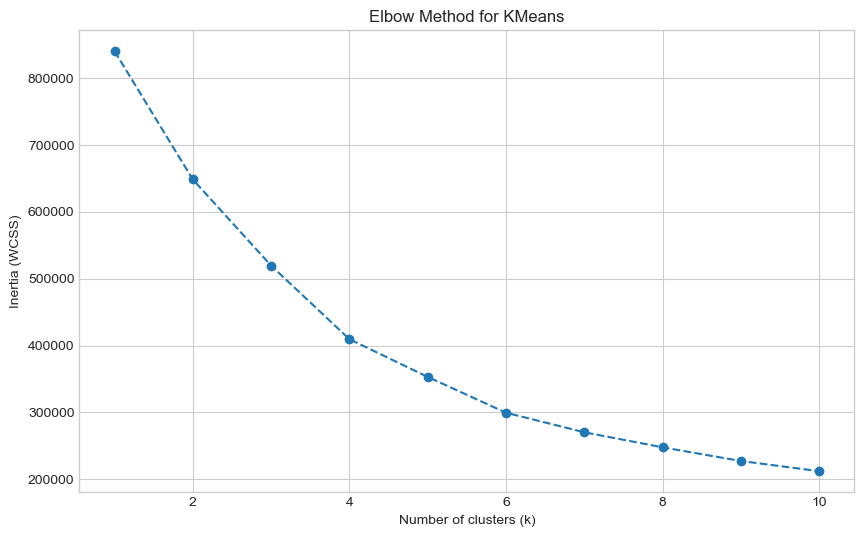

2025-10-19 23:23:43,680 - INFO - KMeans fitted with k=4


Cluster
0          17128
1          60690
2           2224
3          13316
Name: count, dtype: int64

In [24]:
# 11. Determine optimal k (Elbow method) and fit KMeans
inertia = {}
K_RANGE = range(1,11)
for k in K_RANGE:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    km.fit(features_scaled)
    inertia[k] = km.inertia_

# Plot elbow
plt.figure(figsize=(10,6))
plt.plot(list(inertia.keys()), list(inertia.values()), marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for KMeans')
elbow_path = output_dir / 'elbow_method_plot.png'
plt.savefig(elbow_path, dpi=150, bbox_inches='tight')
logging.info('Saved elbow plot to %s', elbow_path)
plt.show()

# Fit final model (choose k based on elbow; default 4)
optimal_k = 4
kmeans_model = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, max_iter=300, random_state=42)
kmeans_model.fit(features_scaled)
customer_df['Cluster'] = kmeans_model.labels_
logging.info('KMeans fitted with k=%s', optimal_k)
display(customer_df[['Cluster']].value_counts().sort_index())


In [25]:
# 12. Analyze segments and create human-readable labels
segment_summary = customer_df.groupby('Cluster').agg({
    'Recency':'mean','Frequency':'mean','Monetary':'mean','Tenure':'mean','avg_days_between_orders':'mean','distinct_categories_purchased':'mean'
}).round(2)
logging.info('Segment summary computed:')
display(segment_summary)

# Map cluster index to descriptive label (example mapping — adjust after inspection)
segment_map = {
    0: 'New Customers',
    1: 'Champions',
    2: 'At-Risk',
    3: 'Potential Loyalists'
}
customer_df['Segment'] = customer_df['Cluster'].map(segment_map).fillna('Other')
display(customer_df[['Segment']].value_counts())

# Save final segmented customers
segments_path = output_dir / 'customer_segments_final.csv'
customer_df.to_csv(segments_path)
logging.info('Saved final segments to %s', segments_path)
segments_path


2025-10-19 23:23:43,708 - INFO - Segment summary computed:


,Recency,Frequency,Monetary,Tenure,avg_days_between_orders,distinct_categories_purchased
Cluster,,,,,,
0,45.96,1.00,136.81,45.96,0.00,1.00
1,289.83,1.01,109.72,289.83,0.00,1.00
2,205.55,2.14,423.73,316.20,84.92,1.77
3,253.78,1.01,738.35,253.84,0.01,1.05


Segment            
Champions              60690
New Customers          17128
Potential Loyalists    13316
At-Risk                 2224
Name: count, dtype: int64

2025-10-19 23:23:44,313 - INFO - Saved final segments to analysis_outputs\feature_engineering_outputs\customer_segments_final.csv


WindowsPath('analysis_outputs/feature_engineering_outputs/customer_segments_final.csv')

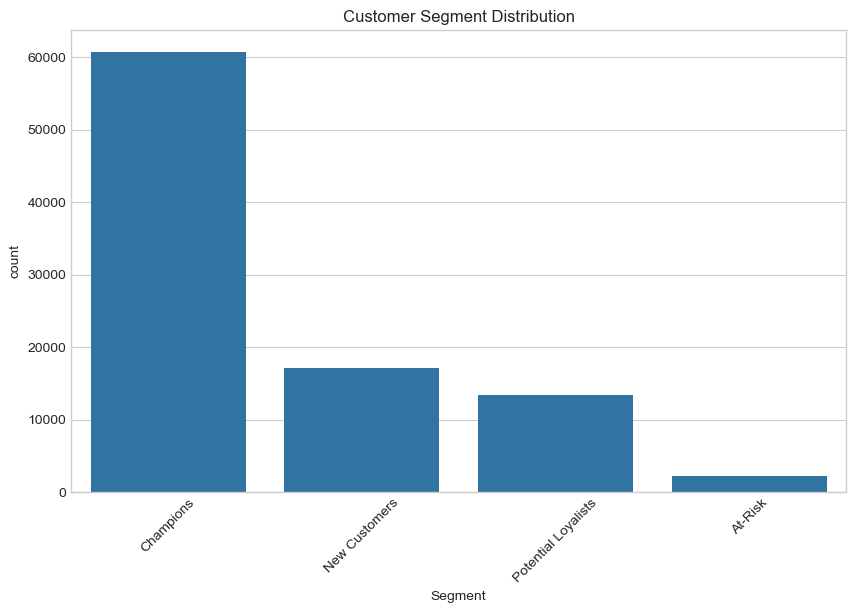

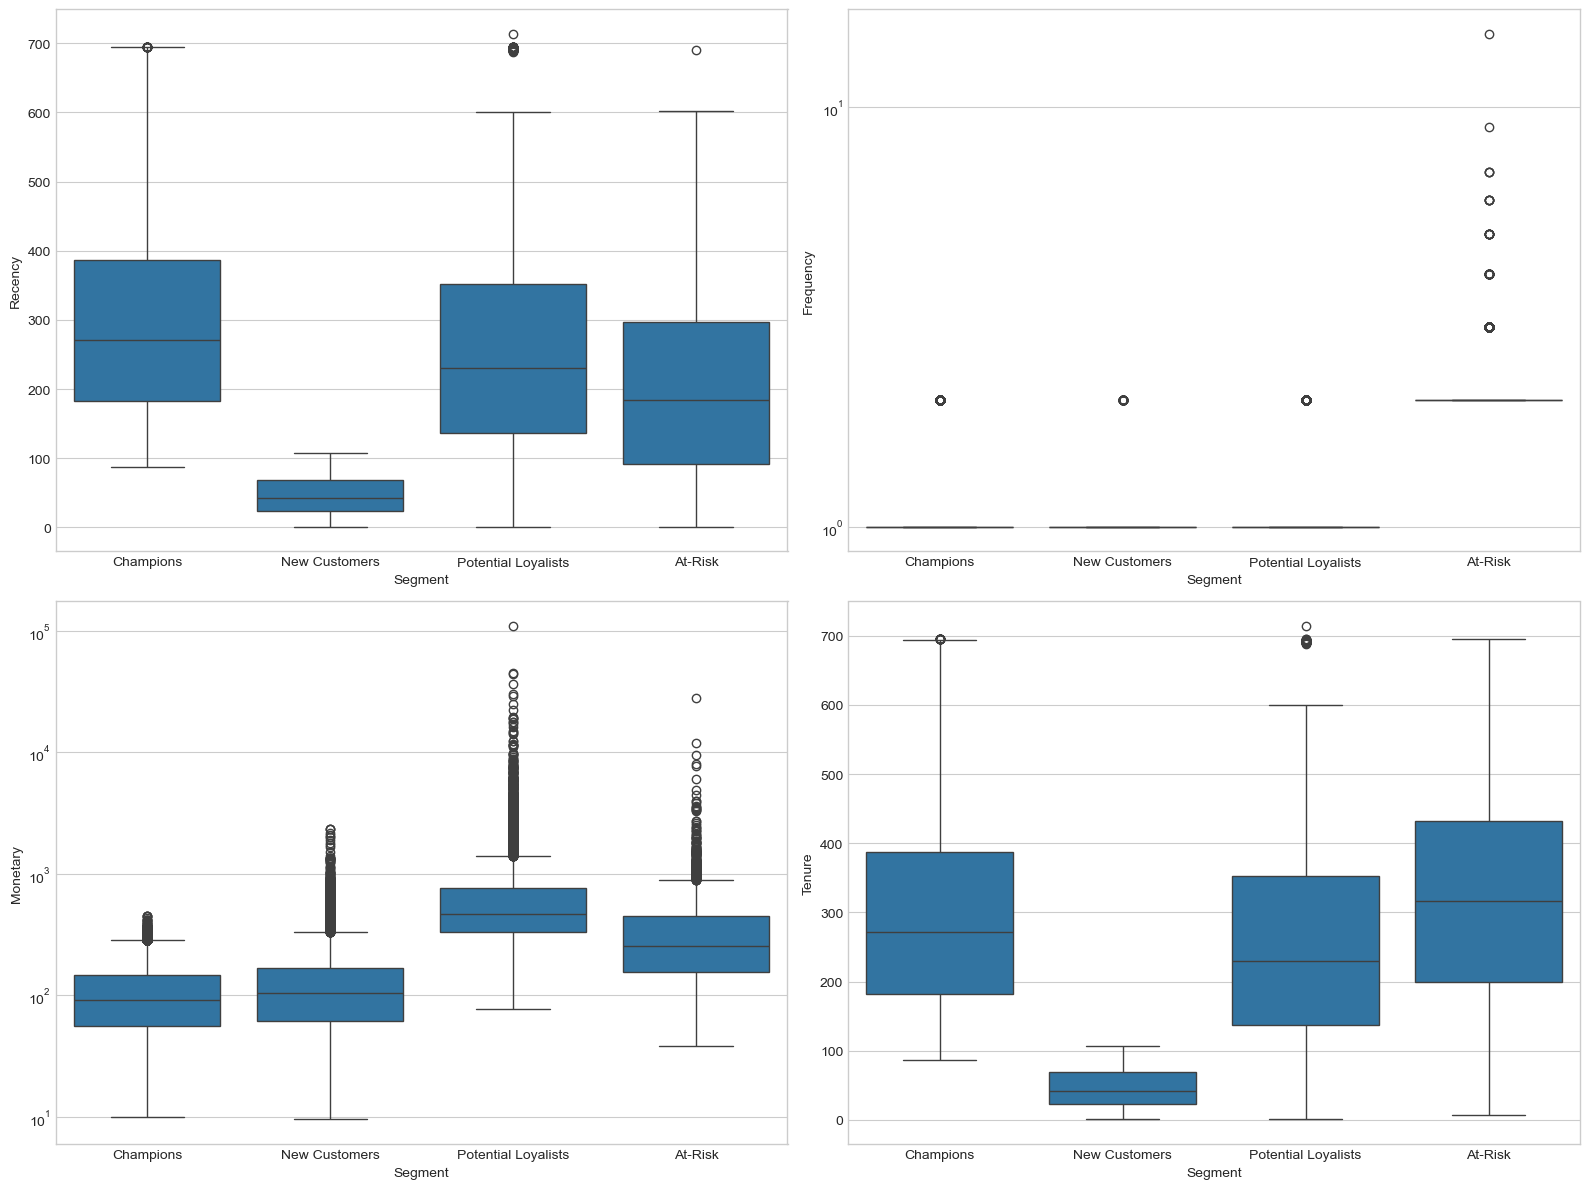

In [26]:
# 13. Visualize segments — distribution and boxplots
plt.figure(figsize=(10,6))
sns.countplot(x='Segment', data=customer_df.reset_index(), order=customer_df['Segment'].value_counts().index)
plt.title('Customer Segment Distribution')
plt.xticks(rotation=45)
seg_dist_path = output_dir / 'segment_distribution.png'
plt.savefig(seg_dist_path, dpi=150, bbox_inches='tight')
plt.show()

# Boxplots of RFM by Segment
features_for_boxplot = ['Recency','Frequency','Monetary','Tenure']
plt.figure(figsize=(16,12))
for i, feat in enumerate(features_for_boxplot, 1):
    plt.subplot(2,2,i)
    sns.boxplot(x='Segment', y=feat, data=customer_df.reset_index(), order=customer_df['Segment'].value_counts().index)
    if feat in ['Frequency','Monetary']:
        plt.yscale('log')
plt.tight_layout()
seg_box_path = output_dir / 'segment_characteristics_boxplots.png'
plt.savefig(seg_box_path, dpi=150, bbox_inches='tight')
plt.show()
